<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preambles" data-toc-modified-id="Preambles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preambles</a></span></li><li><span><a href="#Define-parameters" data-toc-modified-id="Define-parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define parameters</a></span></li><li><span><a href="#Test-using-propagator" data-toc-modified-id="Test-using-propagator-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test using propagator</a></span></li><li><span><a href="#Evolve-using-master-equation-solver" data-toc-modified-id="Evolve-using-master-equation-solver-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evolve using master equation solver</a></span></li><li><span><a href="#Extract-PTM" data-toc-modified-id="Extract-PTM-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Extract PTM</a></span><ul class="toc-item"><li><span><a href="#Ideal-case" data-toc-modified-id="Ideal-case-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Ideal case</a></span></li><li><span><a href="#With-decoherence" data-toc-modified-id="With-decoherence-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>With decoherence</a></span></li><li><span><a href="#Sweep-the-time-here" data-toc-modified-id="Sweep-the-time-here-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Sweep the time here</a></span></li><li><span><a href="#Three-qubits" data-toc-modified-id="Three-qubits-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Three qubits</a></span></li></ul></li></ul></div>

# Preambles

/Users/longnguyen/Documents/GitHub/qtrl/qtrl/benchmarking/tomography.py:297: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if p is not 'I':
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 90
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 90
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 180
/Users/longnguyen/Documents/GitHub/qtrl/qtrl/sequencer/library_tools.py:37: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  prefix is not '' or suffix is not '') else 180


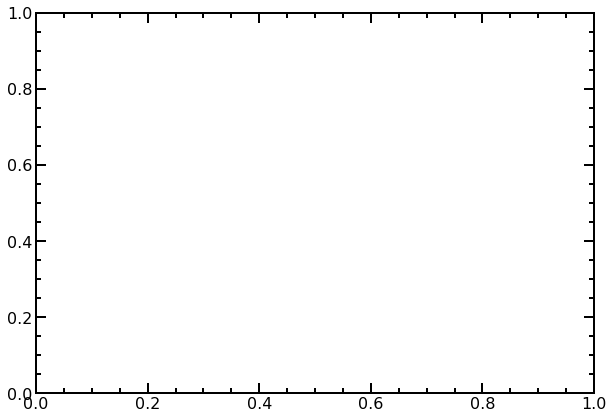

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
import plotting_settings
import scipy.linalg
from Fluxonium_hamiltonians import qchard_rotope as op
sys.path.append('/Users/longnguyen/Documents/GitHub/qtrl/')
from qtrl.benchmarking import tomography
from qtrl.analysis.state_tomography import generate_tomo_pulse_list, binary_arrays_to_bins, standard_tomography, \
    fidelity, purity, project_and_normalize_density_matrix, mcweeny_purification, dm_from_pulse, pauli_matrix, \
    renormalize_expectation_values, expectation_value_rho
from itertools import product

# Define parameters

In [2]:
#Define qubit
wq = 5
H_nodrive = 0.5*wq*sigmaz()

#Define drive
wd=wq
T_gate = 50
T_rise = 10
sigma = 0.25
shape = 'gauss'
drive_freq = wq
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)

#Decoherence
def c_ops_func(t1, t2):
    gamma1 = t1**(-1.0)
    gamma2 = t2**(-1.0)
#     gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sigmam())
    c2 = np.sqrt(gamma2/2.0) *(sigmaz())
    return [c1, c2]

# Test using propagator

0.9999982095111385


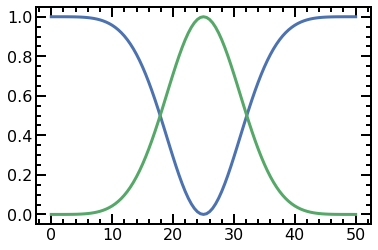

In [3]:
#Evolve using propagator
# c_ops = c_ops(1e3, 1e3)
U_ideal = qeye(2)#sigmax()
state_0 = basis(2,0)
state_1 = basis(2,1)
P0 = state_0*state_0.dag()
P1 = state_1*state_1.dag()

coupl = 1 #MHz
# coupl = coupl*2*np.pi*1e-3
H_drive = coupl*sigmax()
H_dummy = 0*sigmax()
U_nothing = gates.evolution_operator_microwave(-H_nodrive, H_dummy, t_points=t_points,T_gate=T_gate, T_rise = T_rise, sigma = sigma, shape=shape, omega_d=drive_freq, parallel = True)
U_t = gates.evolution_operator_microwave(H_nodrive, H_drive, t_points=t_points,T_gate=T_gate, T_rise = T_rise, sigma = sigma, shape=shape, omega_d=drive_freq, parallel = True)

u0 = U_t[-1].matrix_element(state_0, state_0)
u1 = U_t[-1].matrix_element(state_1, state_1)

phase = np.angle(u1/u0)
single_qu_z = 0
single_qu_z = single_qu_z + state_0*state_0.dag()
single_qu_z = single_qu_z + np.exp(-1.0j*phase)*state_1*state_1.dag()
U_real = single_qu_z*U_t[-1]
U_real = U_t[-1]
U_real = U_nothing * U_t
U_real = U_real[-1]
    
plt.plot(t_points, expect(P0,U_t*state_0))
plt.plot(t_points, expect(P1,U_t*state_0))

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print (fidel)

# Evolve using master equation solver

0.9505015574468867
0.950501557457136


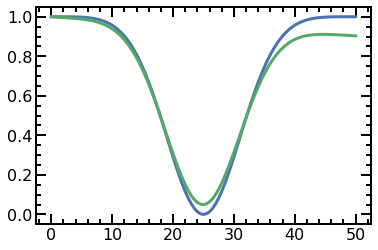

In [4]:
t1 = 5e2
t2 = 2e2
psi_ini = state_0
evol_states_ideal = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, c_ops = [],
                                            T_gate=T_gate, sigma = sigma, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_ideal))

evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_ini, t_points=t_points, c_ops = c_ops_func(t1, t2),
                                            T_gate=T_gate, sigma = sigma, shape=shape, omega_d=drive_freq)
plt.plot(t_points, expect(P0,evol_states_real))

rho_ideal = ket2dm(evol_states_ideal[-1])
rho_real = evol_states_real[-1]
print (qutip.fidelity(rho_ideal, rho_real))
fidel = (rho_real.sqrtm() * rho_ideal * rho_real.sqrtm()).sqrtm().tr()
print (abs(fidel))

# Extract PTM

## Ideal case

<ipython-input-5-32a0092db9d0>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]


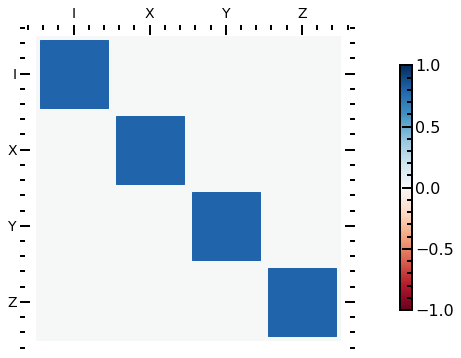

In [5]:
#Very ideal case
prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
gate = qeye(2)#sigmax()
states_in = []
states_out = []
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    psi_out = np.array(ket2dm(gate*psi_in))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)

ptm_ideal = tomography.get_process_matrix(states_in, states_out, physical=True)
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_ideal, xlabels = op_label, ylabels = op_label)
ptm_ideal_0 = np.round(ptm_ideal,10).real
ptm_ideal_0 = ptm_ideal

In [16]:
#Use master equation solver without collapse operators
prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
states_in = []
states_out = []
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = [],
                                            T_gate=T_gate, sigma = sigma, shape=shape, omega_d=drive_freq)
    psi_out = np.array(ket2dm(single_qu_z*evol_states_real[-1]))
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
        
ptm_ideal_1 = tomography.get_process_matrix(states_in, states_out, physical=True)
# ptm_ideal_1 = np.round(ptm_ideal_1,2).real
d = 2
def ptm_fidel(ptm_real, ptm_ideal, d):
    return abs(np.trace(ptm_ideal.T @ ptm_real) / d ** 2)

def gate_fidel(p_fidel,d):
    return (d*p_fidel+1)/(d+1)

print (gate_fidel(ptm_fidel(ptm_ideal_1, ptm_ideal_0, d), d))
print (ptm_fidel(ptm_ideal_1, ptm_ideal_0, d))
print (tomography.process_fidelity(ptm_ideal_1, ptm_ideal_0))

<ipython-input-16-75bc0d13ca84>:2: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]


0.9999998680130259
0.9999998020195389
0.9999998020195389


## With decoherence

In [19]:
#With decoherence
t1 = 1e6
t2 = 1000e3

prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]
states_in = []
states_out = []

gamma1 = t1**(-1.0)
gamma2 = t2**(-1.0)
c1 = np.sqrt(gamma1)*(sigmam())
c2 = np.sqrt(gamma2/2.0) *(sigmaz())
    
for i, prep in enumerate(prep_ops):
    psi_in = prep*state_0
    evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = [c1, c2],
                                            T_gate=T_gate, sigma = sigma, shape=shape, omega_d=drive_freq)
    psi_out = np.array(single_qu_z*evol_states_real[-1]*single_qu_z.dag())
#     psi_out = np.array(evol_states_real[-1])
    psi_in = np.array(ket2dm(psi_in))
    states_in.append(psi_in)
    states_out.append(psi_out)
        
ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
# print ( ptm_real)
print (tomography.process_fidelity(ptm_real, ptm_real))
print (tomography.process_fidelity(ptm_real, ptm_ideal_1))
print (tomography.process_fidelity(ptm_real, ptm_ideal_0))

<ipython-input-19-404525a1723d>:5: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  prep_ops = [qeye(2), ry(-np.pi/2.0), rx(np.pi/2.0), sigmax()]


0.9999004175070845
0.999950206764799
0.999950009316111


## Sweep the time here

In [27]:
t1 = 100e6
t2_array = np.linspace(1,200,100)*1e3
error_array = np.zeros_like(t2_array)

for t2_idx, t2 in enumerate(t2_array):
    states_in = []
    states_out = []
    
    for i, prep in enumerate(prep_ops):
        psi_in = prep*state_0
        evol_states_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0 =psi_in, t_points=t_points, c_ops = c_ops_func(t1, t2),
                                                T_gate=T_gate, sigma = sigma, shape=shape, omega_d=drive_freq)
        psi_out = np.array(evol_states_real[-1])
        psi_in = np.array(ket2dm(psi_in))
        states_in.append(psi_in)
        states_out.append(psi_out)
    ptm_real = tomography.get_process_matrix(states_in, states_out, physical=True)
    error_array[t2_idx]= 1.0-tomography.process_fidelity(ptm_real, ptm_ideal_1)

Text(50, 0.01, '$\\tau_g=50~\\mathrm{ns}$')

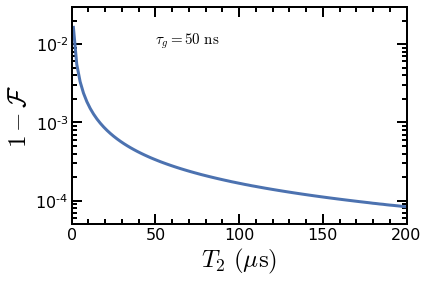

In [29]:
def gate_fidel_anal(t_gate, t2):
    return 

Fp = 1.0-error_array
Fg = (d*Fp+1)/(d+1)
plt.semilogy(t2_array*1e-3, 1-Fg)
plt.ylim([5e-5,3e-2])
plt.xlim([0,200])
plt.xlabel(r'$T_2~(\mathrm{\mu s})$')
plt.ylabel(r'$1-\mathcal{F}$')
plt.text(50,1e-2,r'$\tau_g=50~\mathrm{ns}$')

## Three qubits

In [ ]:
sz1 = tensor(sigmaz(), identity(2), identity(2))
sz2 = tensor(identity(2), sigmaz(), identity(2))
sz3 = tensor(identity(2), identity(2), sigmaz())
sx1 = tensor(sigmax(), identity(2), identity(2))
sx2 = tensor(identity(2), sigmax(), identity(2))
sx3 = tensor(identity(2), identity(2), sigmax())
sm1 = tensor(sigmam(), identity(2), identity(2))
sm2 = tensor(identity(2), sigmam(), identity(2))
sm3 = tensor(identity(2), identity(2), sigmam())
    
def toffoli_H_coupled(freq1, freq2, freq3, g):
    return (0.5*freq1*sz1 + 0.5*freq2*sz2 + 0.5*freq3*sz3 + g*sx1*sx2 + g*sx2*sx3)

def toffoli_collapse_ops(t1,t2):
    gamma1 = 1.0/t1
    gamma2 = 1.0/t2
    gamma_phi = gamma2 - gamma1/2.0
    c1 = np.sqrt(gamma1)*(sm1 + sm2 + sm3)
    c2 = np.sqrt(gamma_phi/2.0) *(sz1 + sz2 + sz3)
    c_ops = [c1, c2]
    return c_ops

freq1 = 5.2541
freq2 = 5.331
freq3 = 5.491
g = 2.74 * 1e-3
T_gate = 340
shape = 'gauss'
drive_freq = freq2
drive_amp = 1
t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
H_nodrive = toffoli_H_coupled(freq1, freq2, freq3, g)
H_drive = drive_amp*(sx1 + sx3)
psi0 = tensor(basis(2,0),basis(2,0),basis(2,0))

t1_toff = 50e3
t2_toff = 60e3
c_ops_toff = toffoli_collapse_ops(t1_toff,t2_toff)

In [ ]:
overlap = 0
for p1_idx in range(6):
    for p2_idx in range(6):
        for p3_idx in range(6):
            psi_ini = tensor(rotation[p1_idx], rotation[p2_idx], rotation[p2_idx])*psi0
            evol_ideal = gates.evolution_psi_microwave(H_nodrive, H_drive, psi0=psi_ini, t=t_points,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            rho_ideal = ket2dm(evol_ideal)
            rho_real = gates.evolution_psi_microwave_diss(H_nodrive, H_drive, psi0=psi_ini, t=t_points, c_ops=c_ops_toff,
                                                    T_gate=T_gate, shape=shape, omega_d=drive_freq)[-1]
            overlap = overlap + (rho_real*rho_ideal).tr()
fidel = abs(overlap)/(6.0**3)
print (fidel)

In [ ]:
print (qutip.Options())

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'
infidelity_array = np.load(figpath+'/CR_detune_vs_fidelity_variedJ_TLS.npy')
detuning_array = np.linspace(50,250,51)*1e-3

plt.figure(figsize = [5,4])
# plt.plot(detuning_array*1e3, infidelity_array[:,0], linewidth = 2, label = r'$J_C=1~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,1], linewidth = 2, label = r'$J_C=5~\mathrm{MHz}$')
# plt.plot(detuning_array*1e3, infidelity_array[:,2], linewidth = 2, label = r'$J_C=10~\mathrm{MHz}$')
plt.plot(detuning_array*1e3, infidelity_array[:,3], linewidth = 2, label = r'$J_C=20~\mathrm{MHz}$')
plt.yscale("log")
plt.xlabel(r"$\Delta/2\pi~\mathrm{(MHz)}$")
plt.ylabel(r'$1-\mathcal{F}$')
# plt.xlim([50,250])
# plt.ylim([5e-5,1e-2])
plt.legend()
plt.tight_layout()
figname = 'CR_gate5.pdf'
plt.savefig(figpath+figname)